In [1]:
include("util_integrate.jl")

# Integration with the rectangles method

Let us try and approximate an integral with the rectangles method:

\begin{align}
I_{a,b}^n(f) = \frac{b-a}{n} \sum_{i=1}^n f(x_i)
\end{align}

where $x_i = a + \frac{b-a}{n} (i+\frac{1}{2})$.

Mathematics tell us that:

\begin{align*}
I_{a,b}^n(f) - \int_a^b f(x) dx = \mathcal{O}\left(\frac{1}{n}\right).
\end{align*}

Let's check what happens in practice...

In [16]:
function integrate(fun, a, b, n, T=Float64)
    a = T(a); b = T(b)
    
    dx  = (b-a)/n
    x   = a + dx/2
    acc = T(0)
    while x<b
        acc += fun(x)*dx
        x += dx
    end
    acc
end

integrate (generic function with 2 methods)

## A first test case

As a test case:
\begin{align}
\int_0^1 x^3 dx = \frac{1}{4}
\end{align}

In [17]:
cube(x) = x*x*x
integrate(cube, 0, 1, 10000)

0.2499999987499343

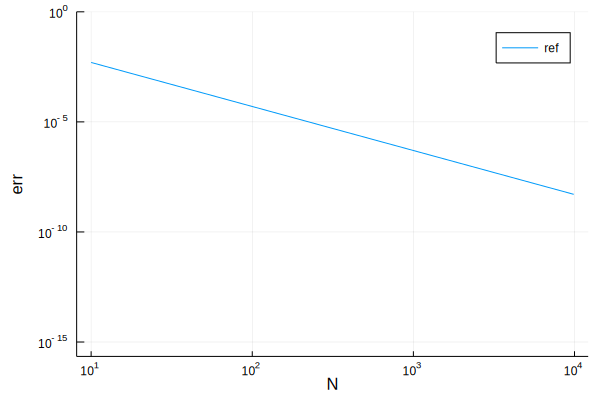

In [18]:
test(Float64) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
    
    (ref=ϵ,)
end

## Can we use Float32?

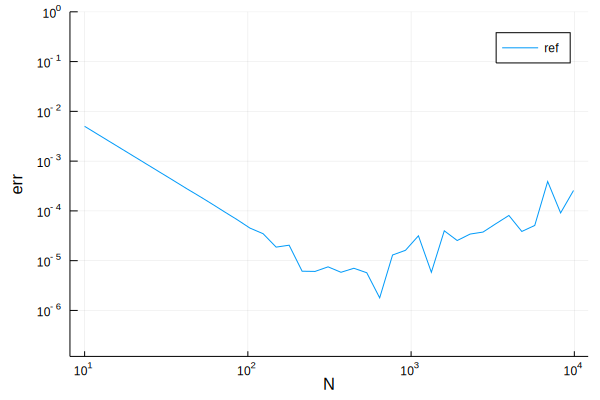

In [19]:
test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
    
    (ref=ϵ,)
end

## Floating-Point accuracy assessment

A first way to attribute "bad behaviour" to FP arithmetic is to use something else as reference. For example Rationals.

Even if Julia didn't have a built-in Rational type, it would be easy to develop one...

In [20]:
integrate(cube, 0, 1, 100, MyRational{BigInt})

19999/80000

Which is approximately as fast!

In [21]:
@btime integrate(cube, 0, 1, 100, MyRational{BigInt})

  770.333 μs (19527 allocations: 369.63 KiB)


19999/80000

In [22]:
@btime integrate(cube, 0, 1, 100, Rational{BigInt})

  620.143 μs (17334 allocations: 325.64 KiB)


19999//80000

<br/>

Conclusion: "bad behaviour" is indeed caused by round-off errors:

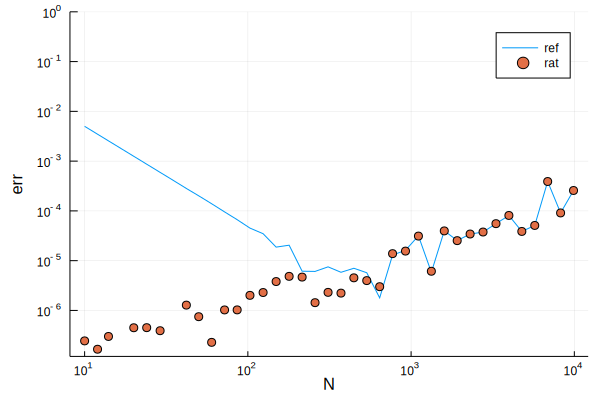

In [9]:
test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
        
    v_rat = integrate(fun, 0, 1, n, MyRational{BigInt}) |> to_float
    ϵ_rat = abs(v - v_rat)/abs(v_rat)
    
    (ref=ϵ, rat=ϵ_rat)
end

<br/>

What if we wanted to compute something that is not a polynomial?
\begin{align}
\int_{0,1}\sqrt{x}\;dx
\end{align}

<br/>

Rational arithmetic is slow, and can only take us so far. Enter Stochastic Arithmetic!

In [10]:
using StochasticArithmetic

@reliable_digits integrate(cube, 0, 1, 1000, SFloat32)

(0.25000387f0, 5.795391f0)

In [11]:
@btime @reliable_digits integrate(cube, 0, 1, 10_000, SFloat32)
@btime integrate(cube, 0, 1, 10_000, MyRational{BigInt})

  20.510 ms (400122 allocations: 6.11 MiB)
  214.737 ms (3272781 allocations: 58.56 MiB)


199999999/800000000

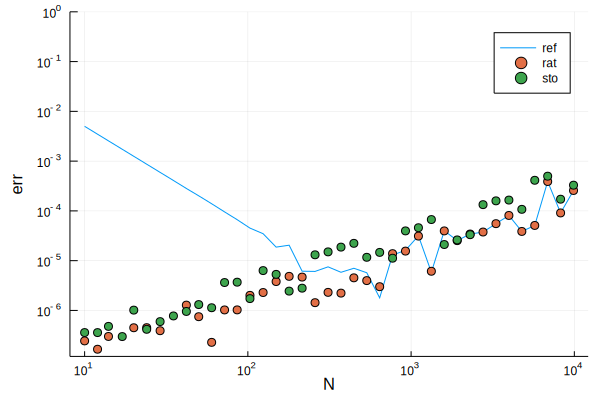

In [12]:
using StochasticArithmetic: SFloat

test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
        
    v_rat = integrate(fun, 0, 1, n, MyRational{BigInt}) |> to_float
    ϵ_rat = abs(v-v_rat)/abs(v_rat)

    v_sto,_ = @reliable_digits integrate(fun, 0, 1, n, SFloat{T})
    ϵ_sto = abs(v_sto-v)/abs(v)
    
    (ref=ϵ,
     rat=ϵ_rat,
     sto=ϵ_sto)
end

## A corrected version

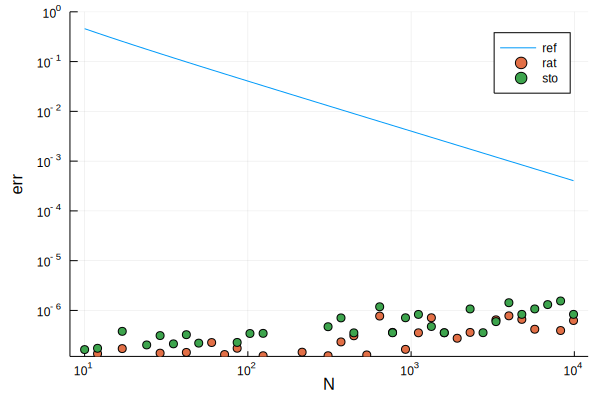

In [13]:
function integrate(fun, a, b, n, T=Float64)
    a = T(a); b = T(b)
    
    dx  = (b-a)/n
    acc = T(0)
    for i in 1:n
        x = a + i*dx + dx/2
        acc += fun(x)*dx
    end
    acc
end

test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
        
    v_rat = integrate(fun, 0, 1, n, MyRational{BigInt}) |> to_float
    ϵ_rat = abs(v - v_rat)/abs(v_rat)

    v_sto,_ = @reliable_digits integrate(fun, 0, 1, n, SFloat{T})
    ϵ_sto = abs(v_sto-v)/abs(v)
    
    (ref=ϵ,
     rat=ϵ_rat,
     sto=ϵ_sto)
end